In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')  # Set whitegrid style from Seaborn
#import mplfinance as mpf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import plotly.express as px
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

from collections import defaultdict
from scipy import stats

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)

#Keras
import tensorflow as tf

# keras keras

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate,Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import Sequential
#from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Dropout, GRU, Bidirectional,Dense
from keras.layers import GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.layers import Embedding, LSTM,Dense
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers import concatenate
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Time-series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

#KERAS GRID Search
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.activations import swish
#
import math
#

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error
#
from datetime import datetime
from datetime import timedelta
#
# Load the model
from tensorflow.keras.models import load_model
#iimport pickle
import pickle

### FUNCTIONS

In [35]:
### FUNCTIONS
#Function to separate the DATA for LSTM
def createXY(dataset, n_lags):

    dataX, dataY = [], []

    for i in range(n_lags, len(dataset)):
            dataX.append(dataset[i - n_lags:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])

    return np.array(dataX),np.array(dataY)

In [36]:
#Defining Various Functions
#def mean_error(y_true, y_pred):
#   error = y_true - y_pred
#   return np.mean(error) 

def mean_error(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    error_sum = 0
    for pred, true in zip(y_pred, y_true):
        error_sum += true + (-pred)
    return error_sum / len(y_true)


def mean_directional_accuracy(actual, predicted):
    """
    Calculates the Mean Directional Accuracy (MDA) for two time series.
    MDA measures the percentage of times the forecast and the actual values move in the same direction (i.e., both increase or both decrease).
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The MDA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check if inputs are of the same length and non-empty
    if len(actual) != len(predicted):
        raise ValueError("The lengths of actual and predicted must be the same.")
    if len(actual) < 2:
        raise ValueError("The length of the time series must be at least 2 to compute MDA.")
    
    # Calculate the signs of the differences between consecutive values
    actual_diff = np.diff(actual)
    actual_signs = np.sign(actual_diff)
    predicted_diff = np.diff(predicted)
    predicted_signs = np.sign(predicted_diff)
    
    # Count the number of times the signs are the same
    num_correct = np.sum(actual_signs == predicted_signs)
    
    # Calculate the MDA value
    mda = num_correct / (len(actual) - 1)
    
    return mda
#
def directional_accuracy(actual, predicted):
    """
    Calculates the Directional Accuracy (DA) for two time series.
    
    Parameters:
    actual (array-like): The actual values for the time series.
    predicted (array-like): The predicted values for the time series.
    
    Returns:
    float: The DA value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check if inputs are of the same length and non-empty
    if len(actual) != len(predicted):
        raise ValueError("The lengths of actual and predicted must be the same.")
    if len(actual) < 2:
        raise ValueError("The length of the time series must be at least 2 to compute DA.")
    
    # Calculate differences between consecutive values
    actual_diff = np.diff(actual)
    predicted_diff = np.diff(predicted)
    
    # Calculate the indicator function for directional accuracy
    indicator = (predicted_diff * actual_diff) > 0
    
    # Count the number of correct directions
    num_correct_directions = np.sum(indicator)
    
    # Calculate the DA value
    da = num_correct_directions / (len(actual) - 1)
    
    return da


In [37]:
# Define the evaluation function
def evaluation(y_test, y_pred, data_test,title):
    # Plot the actual vs predicted values
    fig = plt.figure(figsize=(8, 3))
    plt.plot(y_test, color='red', label='Actual')
    plt.plot(y_pred, color='blue', label='Predicted')
    #plt.xticks(np.arange(0, len(df_ai_test), 100), df_ai_test.index[np.arange(0, len(df_ai_test), 100)], rotation=45)
    plt.title(f"Predictions vs Actual Data using {title}")
    #plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('EUR')
    plt.legend()
    plt.grid(False)

    # Assuming data_test.index is a datetime index
    plt.xticks(np.arange(0, len(data_test), 100), data_test.index[np.arange(0, len(data_test), 100)].strftime('%Y-%m-%d'), rotation=0)

    # Calculate metrics
    #mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    me = mean_error(y_test, y_pred)
    mda = mean_directional_accuracy(y_test, y_pred)
    da  = directional_accuracy(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Round metrics for display
   # mape = np.round(mape, 3)
    mae = np.round(mae, 3)
    mse = np.round(mse, 3)
    rmse = np.round(rmse, 3)
    me = np.round(me, 3)
    mda = np.round(mda, 3)
    da= np.round(da, 3)
    r2 = np.round(r2, 3)

    # Print metrics
    print('MAE: %f  --  MSE: %f  --  RMSE: %f  --  ME: %f  --  MDA: %f  --  DA: %f  --  R2: %f' % 
          (mae, mse, rmse, me, mda, da, r2))

    return mae, mse, rmse, me, mda, da, r2

### LOAD TRAINED MODEL AND SCALER

In [38]:
#Load the model
model_lstm = load_model('LSTM_MODEL_KERAS.keras')
#Load the scaler
scaler = pickle.load(open('SCALERLSTM.pickle', 'rb'))

c:\Users\kathe\miniconda3\envs\DEH\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 



### LOAD DATA WITH HOLIDAYS DAYS WEEKS MONTH IN SIN/COS. NEED TO USE NOTEBOOK CreateFeatureDataFrames

In [39]:
df_ai=pd.read_csv('allfeatures_sin.csv')

In [40]:
df_ai.head()

,Unnamed: 0,datetime_from,price,price1,price2,price3,is_weekend,is_holiday,dayofweek_sin,dayofweek_cos,month_sin,month_cos,hour_sin,hour_cos
0,0,2023-07-28 00:00:00,107.99,98.83,95.05,107.123,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.000000,1.000000
1,1,2023-07-28 01:00:00,106.04,95.19,93.70,104.801,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.258819,0.965926
2,2,2023-07-28 02:00:00,106.10,97.00,87.98,102.977,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.500000,0.866025
3,3,2023-07-28 03:00:00,105.00,100.36,89.45,109.143,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.707107,0.707107
4,4,2023-07-28 04:00:00,102.22,109.23,101.46,116.560,0,0,-0.433884,-0.900969,1.224647e-16,-1.0,0.866025,0.500000


In [41]:
df_ai.drop(columns=['Unnamed: 0'],inplace=True, axis = 1)

In [42]:
df_ai.shape

(8256, 13)

In [43]:
df_ai['datetime_from'] = pd.to_datetime(df_ai['datetime_from'])
df_ai = df_ai.set_index('datetime_from')
df_ai = df_ai.asfreq('1H')
df_ai = df_ai.sort_index()
(df_ai.index == pd.date_range(start=df_ai.index.min(),end=df_ai.index.max(),freq=df_ai.index.freq)).all()

True

In [44]:
df_ai.shape

(8256, 12)

In [45]:
#Select the past 48 Hours_ These are the 48 LAGS to put into the model to find the next hour. LAST SEQUENCE of DATA
df_48 = df_ai.loc['2024-06-30 00:00:00':'2024-07-01 23:00:00']

In [46]:
#Keep the data for the next day to Predict
df_last_day = df_ai.loc['2024-07-02 00:00:00':'2024-07-02 23:00:00']

### DEFINE PARAMETERS

In [47]:
#Parameters
lag = 48
num_features = df_ai.shape[1]
next_predictions = 24

### SCALE THE DATA of PAST OBSERVATIONS DF_48

In [48]:
#Scale the DATA with IMPORTED SCALER

data_scaled = scaler.transform(df_48.values)

#Need this to be (48,12)
data_scaled.shape

(48, 12)

### PREDICT NEXT 24 HOURS

In [49]:
#Model Expects an input of (1, 48, 12) to make a prediction of (1,)
#RESHAPE THE DATA (1, lag, num_features)
last_sequence = data_scaled.reshape((1, lag, num_features))  # (1, 48, 12)

In [50]:
# Initialize the predictions dictionary
predictions = {
    'pred': [],
    'actual': [],
    'price1': [],
    'price2': [],
    'price3': []
}

# Predict 24 hours ahead (next_predictions)
for i in range(next_predictions):
    # Predict the next hour
    next_prediction = model_lstm.predict(last_sequence)
    
    # Inverse scale the prediction for the first feature
    prediction_reverselyscaled = scaler.inverse_transform(np.repeat(next_prediction, num_features, axis=-1))[:, 0]
    
    # Get the next timestamp
    next_timestamp = df_48.index[-1] + pd.Timedelta(hours=i + 1)
    #print('next_timestamp: ',next_timestamp)
    
    # Extract the next feature values from df_last_day for the next timestamp
    if next_timestamp in df_last_day.index:
        next_features = df_last_day.loc[next_timestamp, ['price1', 'price2', 'price3', 'is_weekend', 'is_holiday', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos']].values
    else:
        next_features = np.zeros(num_features - 1)  # Default to zeros if timestamp is out of range
        print('Timestamp not in Next Day !!!')
    
    # Combine the predicted value with the next feature values
    new_row = np.concatenate(([prediction_reverselyscaled[0]], next_features))
    # Scale the new row
    new_row_scaled = scaler.transform(new_row.reshape(1, -1)).flatten()

    # Update the last_sequence with the new prediction and feature values
    next_input = np.append(last_sequence[0, 1:, :], [new_row_scaled], axis=0)  # Shift and append the prediction
    last_sequence = next_input.reshape((1, lag, num_features))
    
    # Update the predictions dictionary
    predictions['pred'].append(prediction_reverselyscaled[0])
    if next_timestamp in df_last_day.index:
        predictions['actual'].append(df_last_day.loc[next_timestamp, 'price'])
        predictions['price1'].append(df_last_day.loc[next_timestamp, 'price1'])
        predictions['price2'].append(df_last_day.loc[next_timestamp, 'price2'])
        predictions['price3'].append(df_last_day.loc[next_timestamp, 'price3'])
    else:
        predictions['actual'].append(None)  # Append None if the timestamp is out of range
        predictions['price1'].append(None)
        predictions['price2'].append(None)
        predictions['price3'].append(None)
    
    # Debugging: Print the current prediction and last sequence
    #print(f"Prediction {i+1}: {predictions['pred'][-1]}")
    #print(f"Actual {i+1}: {predictions['actual'][-1]}")
    #print(f"last_sequence before update: {last_sequence[0, -1, :]}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
next_timestamp:  2024-07-02 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next_timestamp:  2024-07-02 01:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
next_timestamp:  2024-07-02 02:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next_timestamp:  2024-07-02 03:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
next_timestamp:  2024-07-02 04:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next_timestamp:  2024-07-02 05:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
next_timestamp:  2024-07-02 06:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next_timestamp:  2024-07-02 07:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
next_timestamp:  2024-07-02 08:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
next_timestamp:  2024-07-02 09:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
next_timestamp:  2024-07-02 10:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
next_timestamp:  2024-07-02 11:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
next_timestamp:  2024-07-02 12:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━

In [53]:
# Print the 24-hour ahead predictions
print("24-hour ahead predictions:")
print('Actual Prices: ',predictions['actual']), print('Predicted Prices: ',predictions['pred']),print('Price1: ',predictions['price1']),print('Price2: ',predictions['price2']), print('Price3: ',predictions['price3'])

24-hour ahead predictions:
Actual Prices:  [99.84, 95.52, 95.23, 100.56, 122.79, 111.33, 107.43, 98.58, 86.83, 87.3, 87.62, 87.23, 90.0, 98.22, 103.0, 105.11, 107.81, 130.15, 171.24, 120.19, 114.05, 106.91, 100.1, 97.46]
Predicted Prices:  [103.1127, 99.31838, 98.43828, 101.115685, 109.89328, 127.51267, 135.05972, 120.35492, 108.59084, 102.09268, 100.96645, 103.2295, 107.460464, 111.45182, 121.52858, 132.50204, 163.35445, 236.04121, 322.9752, 236.20976, 156.47223, 121.15267, 107.81273, 96.20514]
Price1:  [121.26, 114.02, 115.74, 120.53, 139.18, 141.21, 132.88, 121.5, 110.53, 105.25, 106.19, 109.59, 109.01, 123.32, 138.23, 185.26, 251.67, 290.56, 287.71, 226.52, 163.51, 134.43, 96.33, 93.89]
Price2:  [104.18, 103.18, 102.94, 106.32, 119.03, 125.14, 113.0, 95.66, 86.53, 81.18, 81.58, 87.06, 92.54, 100.39, 116.62, 114.67, 155.64, 239.54, 278.15, 209.92, 137.36, 115.99, 110.49, 101.37]
Price3:  [95.612, 93.174, 93.678, 104.669, 122.26, 149.214, 128.035, 105.012, 87.162, 78.436, 73.386, 73.

(None, None, None, None, None)

### SHOW A COMBINATORY PLOT OF ALL. IN REAL LIFE I WILL NOT HAVE THE ACTUAL

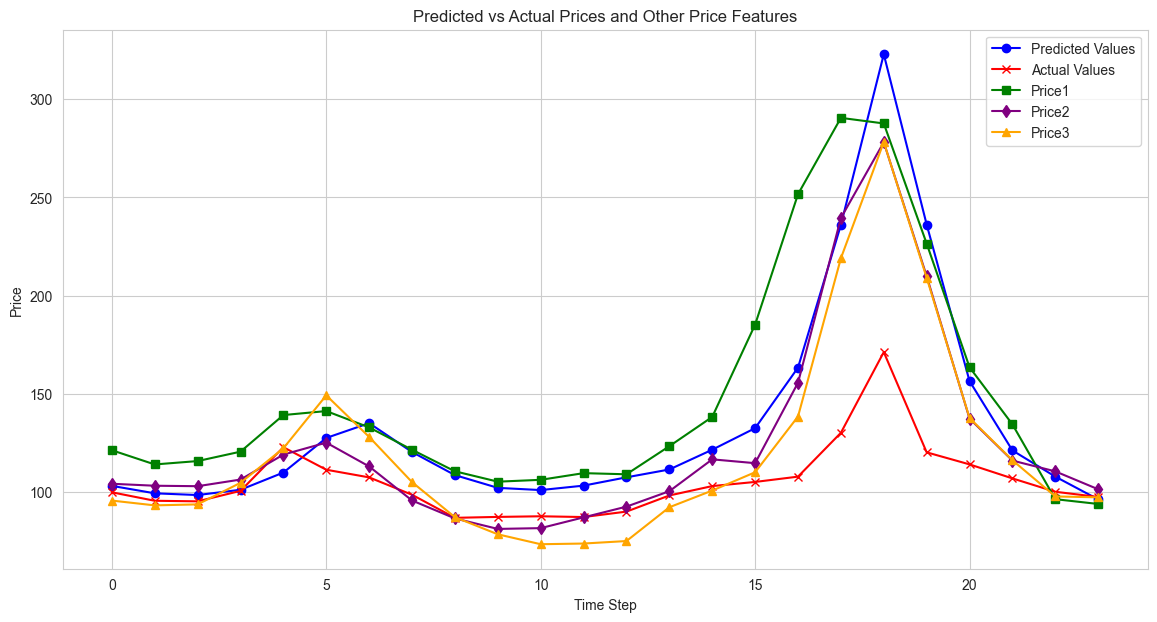

In [54]:
# Create a line graph to show the predictions and actual values
plt.figure(figsize=(14, 7))
plt.plot(predictions['pred'], label='Predicted Values', color='blue', marker='o')
plt.plot(predictions['actual'], label='Actual Values', color='red', marker='x')
plt.plot(predictions['price1'], label='Price1', color='green', marker='s')
plt.plot(predictions['price2'], label='Price2', color='purple', marker='d')
plt.plot(predictions['price3'], label='Price3', color='orange', marker='^')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.title('Predicted vs Actual Prices and Other Price Features')
plt.legend()
plt.show()


### SHOW A COMBINATORY PLOT OF ALL. IN REAL LIFE I WILL NOT HAVE THE ACTUAL

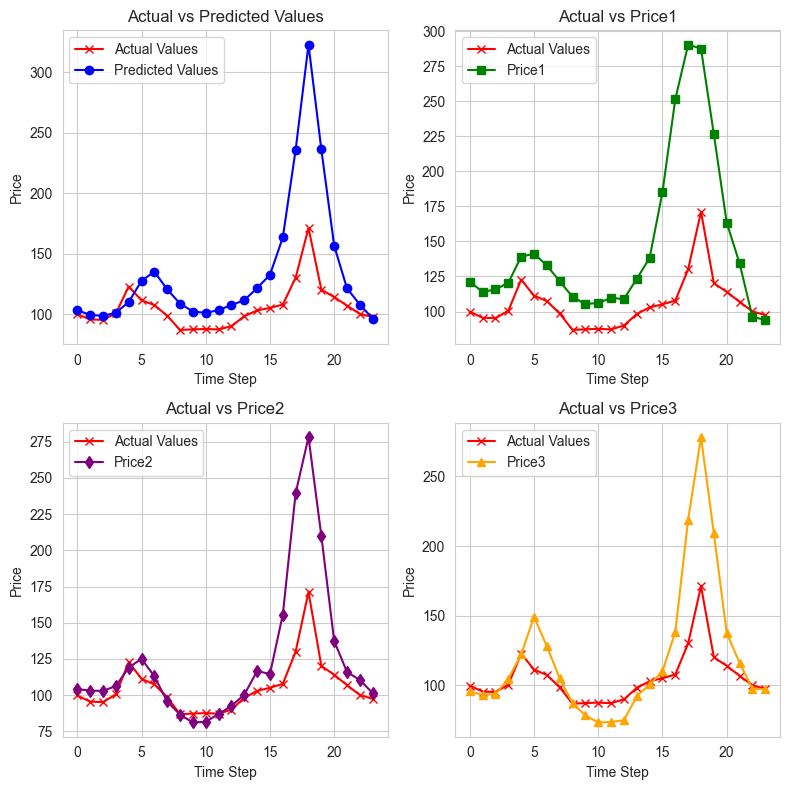

In [55]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot actual vs predicted values
axs[0, 0].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[0, 0].plot(predictions['pred'], label='Predicted Values', color='blue', marker='o')
axs[0, 0].set_xlabel('Time Step')
axs[0, 0].set_ylabel('Price')
axs[0, 0].set_title('Actual vs Predicted Values')
axs[0, 0].legend()

# Plot actual vs price1
axs[0, 1].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[0, 1].plot(predictions['price1'], label='Price1', color='green', marker='s')
axs[0, 1].set_xlabel('Time Step')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Actual vs Price1')
axs[0, 1].legend()

# Plot actual vs price2
axs[1, 0].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[1, 0].plot(predictions['price2'], label='Price2', color='purple', marker='d')
axs[1, 0].set_xlabel('Time Step')
axs[1, 0].set_ylabel('Price')
axs[1, 0].set_title('Actual vs Price2')
axs[1, 0].legend()

# Plot actual vs price3
axs[1, 1].plot(predictions['actual'], label='Actual Values', color='red', marker='x')
axs[1, 1].plot(predictions['price3'], label='Price3', color='orange', marker='^')
axs[1, 1].set_xlabel('Time Step')
axs[1, 1].set_ylabel('Price')
axs[1, 1].set_title('Actual vs Price3')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

MAE: 30.277000  --  MSE: 2385.308000  --  RMSE: 48.840000  --  ME: -29.098000  --  MDA: 0.783000  --  DA: 0.783000  --  R2: -6.536000
MAE: 42.854000  --  MSE: 3702.886000  --  RMSE: 60.851000  --  ME: -42.242000  --  MDA: 0.739000  --  DA: 0.739000  --  R2: -10.699000
MAE: 20.525000  --  MSE: 1469.200000  --  RMSE: 38.330000  --  ME: -18.916000  --  MDA: 0.826000  --  DA: 0.826000  --  R2: -3.642000
MAE: 20.571000  --  MSE: 1314.432000  --  RMSE: 36.255000  --  ME: -14.646000  --  MDA: 0.783000  --  DA: 0.783000  --  R2: -3.153000


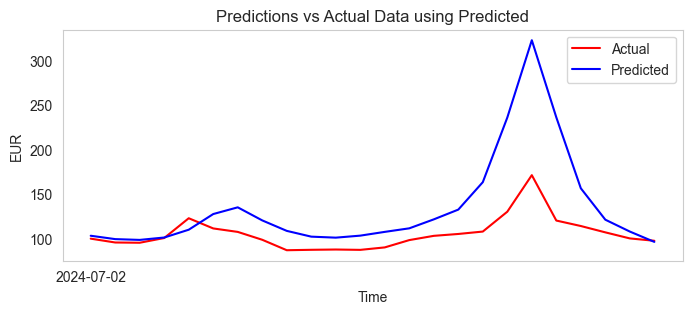

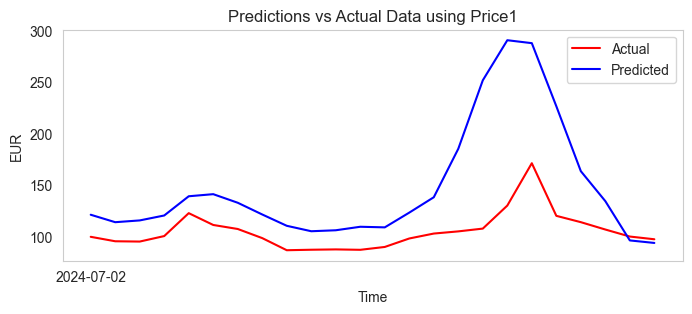

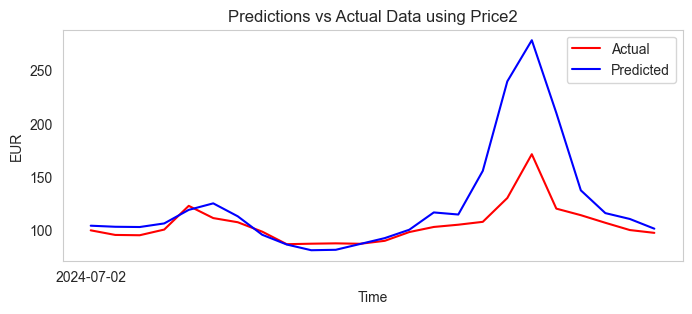

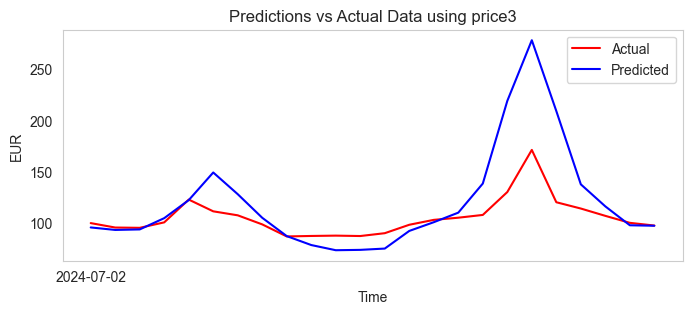

In [56]:
# Evaluate Scores
mae, mse, rmse, me, mda, da, r2 = evaluation(predictions['actual'], predictions['pred'], df_last_day,'Predicted')
mae, mse, rmse, me, mda, da, r2 = evaluation(predictions['actual'], predictions['price1'], df_last_day,'Price1')
mae, mse, rmse, me, mda, da, r2 = evaluation(predictions['actual'], predictions['price2'], df_last_day,'Price2')
mae, mse, rmse, me, mda, da, r2 = evaluation(predictions['actual'], predictions['price3'], df_last_day,'price3')